# **First (serious) training of a Neural Network!**

**Disclaimer**: large parts of the lab are taken from [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) by [Soumith Chintala](http://soumith.ch/) and lectures material of [Sebastian Goldt](https://datascience.sissa.it/research-unit/12/theory-of-neural-networks).

In [1]:
### Some starting stuff ####

%matplotlib inline

import numpy as np

import torch
import torch.nn as nn # Importing the neural network library
from torchvision import datasets, transforms # Transformation contains, i.e., normalization

import matplotlib as mpl
import matplotlib.pyplot as plt

# To plot in a better way
plt.rc("font", **{"size": 12})
plt.rc("lines", linewidth=2.0)
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 2

# **Definition of Neural Networks by means of ``PyTorch``**

The ``torch.nn`` package is used to define and train a Neural Network (model definition). The package depends on ``autograd`` that performs the differentiation.

A Neural Network is defined as ``nn.Module`` (that is a class) and its main features are, we need to define some functions, inside, such as: 
* the layers, --> struction that gives me idea in which way the layer are connected
* the ``forward`` method that process the ``input`` to predict an ``output``.

The main passages of the training procedure are:
- The definition of the neural network and of its learnable parameters (
  weights, bias, regulatirations)
- Perform a prediction over some ``inputs`` by means of a law (weighted layers and activation functions)
- evaluate the loss (i.e. a measure to understand the distance between the prediction and the ``output``)
- use back propagation on the trainable paramters parameters
- update the trainable parameters (gradient descent-based startegies).

**Summarizing**: 
1. Forward
2. Loss
3. Backpropagation
4. Repeat again and again untile you get the right value of loss

**What is means Regularization?** Change the function that you want to minimize to penalize stuff in different way --> you are constraining to go along a direction or onother

**Let us define the Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Build the net inheriting  the data from nn.Module
class Net(nn.Module):

    def __init__(self): # In the constructor we define the layer of the NN
        super(Net, self).__init__()
        # 3 Layer
        self.fc1 = nn.Linear(784, 100) # Linear one where 784 are the initial pixel 28 x 28 (fully connected)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10) # Where 10 are the different final label that I want to predict
        # self.apply(self._init_weights) # If you want to initialize the weight

    """
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
    """

    # Activation 
    def forward(self, x):  ### Forward law ----> prediction
        x = F.relu(self.fc1(x)) # The input is transformed, thanks to the ReLu in the result of the first layer 
        x = F.relu(self.fc2(x)) 

        # So I have 3 layer with 2 ReLu and after a Identity function
        x = self.fc3(x) # Identity --> we do NOT apply the ReLu
        
        return x


seed_num = 0
torch.manual_seed(seed_num)
net = Net()
print(net)

# By defoult I have the bias

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


Only the defintion of the function ``forward`` is needed, since the backward is directly defined for you by ``autograd``.
The ``forward`` function is a law where all the Tensors operations are admitted.




Let us give a look to the parameters in ``net.parameters()``

In [3]:
params = list(net.parameters()) # All the parameters put in a list: weight and bias for each layer (3 x 2 = 6)
print(len(params))
print(params[0].size())  # fc1 .weight
print(params[1].size())
print(params[2].size())
print(params[3].size())
print(params[4].size())
print(params[5].size())

6
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


_**Question time!**_: why is the number of parameters 6? We have only three layers...

_**Let give it a try**_: we define a random 28x28 = 784 ``input``.

_**Question time!**_: why do we need a 28x28 = 784 ``input``?



In [4]:
input = torch.randn(1, 784) # Dimension that I need to give in input to perform an evaluation
out = net(input)
print(out)

tensor([[ 0.1824,  0.0367, -0.1264, -0.1809,  0.0431, -0.0219,  0.0701,  0.0807,
          0.1693, -0.0903]], grad_fn=<AddmmBackward0>)


We now use the function ``zero_grad`` to set the gradient at zero. It is a good practise because for each mini-batch we want to forget the information about the gradient (otherwise it is accumulated).
We now use back propagation over a random gradient.



In [ ]:
net.zero_grad() # With zero_grad() we reset the gradients of the neural network parameters that have been accumulated previously
out.backward(torch.randn(1, 10))

**Be careful!** ``torch.nn`` is able to only work with batches (i.e. more than one ``input`` with some features). If you want to work with a single sample, use the command ``input.unsqueeze(0)`` to add a fake dimension related to the batch size.



**A brief recap: the features we are dealing with are...**  
-  ``torch.Tensor``: the ``PyTorch`` _multi-dimensional array_ that supports ``autograd`` (and, thus, ``backward()`` operation). 
-  ``nn.Module``: it is the _definition of the Neural Network_ with information about parameters, layers and forward law.
-  ``nn.Parameter``: a Tensor with all the parameters (the bias are present by default!) authomatically generated from the layers.

**A brief recap: we...**
* defined the net
* postprocessed the input thanks to the forward law
* have been able to compute gradients

**There is something missing though!**
* The loss --> functional of the optimization problem
* the update of the parameters.

# **The Loss**
The loss is a function that evaluates how far the prediction is from the target (i.e. the _known output_ of the dataset). The ``Torch.nn`` has many losses, [give a look](https://pytorch.org/docs/nn.html#loss-functions)!
The most common is the ``nn.MSELoss``, i.e. the mean-squared error
between the prediction and the given data.


In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example --> random number
print(target.shape)
target = target.view(1, 10)  # make it the same shape as output of the net, you can use target.view(1, -1) [equivalent]

# MSE the most common and most intuitive, but not used in general
criterion = nn.MSELoss() # Import the loss from torch (there are a lot of defined loss in this package)

loss = criterion(output, target)
print(loss) # Tell us the discrepancy: output of the MSE apply to this case

torch.Size([10])
tensor(1.3280, grad_fn=<MseLossBackward0>)


# **Backpropagation**

To perform backpropagation on the loss we have to call ``loss.backward()``. But, as already said, first thing first: clear the existing gradients to avoid accumulating existing information.



In [ ]:
net.zero_grad()     # zeroes the gradient --> ?
print('fc1.bias.grad before backward')
print(net.fc1.bias.grad)

loss.backward()

print('fc1.bias.grad after backward')
print(net.fc1.bias.grad)

fc1.bias.grad before backward
None
fc1.bias.grad after backward
tensor([ 0.0058,  0.0000,  0.0281,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0302, -0.0170,  0.0000, -0.0098,  0.0006,
         0.0120,  0.0000,  0.0000,  0.0000, -0.0157,  0.0286, -0.0168, -0.0034,
         0.0000,  0.0006, -0.0182,  0.0000,  0.0175,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0089,  0.0000, -0.0038,  0.0000,  0.0000,  0.0119, -0.0102,
         0.0000, -0.0144,  0.0266,  0.0000,  0.0079, -0.0142, -0.0155, -0.0121,
         0.0107,  0.0000,  0.0145,  0.0000,  0.0000,  0.0000,  0.0157,  0.0007,
         0.0164,  0.0000,  0.0125, -0.0099, -0.0070,  0.0000, -0.0291,  0.0274,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0381,  0.0000,  0.0083,
         0.0355, -0.0167, -0.0361,  0.0167,  0.0000,  0.0000, -0.0113,  0.0068,
        -0.0195,  0.0000, -0.0136,  0.0000, -0.0003,  0.0317,  0.0495,  0.0291,
         0.0039,  0.0000,  0.0000,  0.0000, -0.0158,  0.

# **The update**

We have seen that the simplest way to update the parameters is the Stochastic Gradient Descent:

     ``weight = weight - learning_rate * weight_gradient``
     ``bias = bias - learning_rate * bias``


We can implement it by hand as

    learning_rate = 0.01
    for p in net.parameters():
        p.data.sub_(p.grad.data * learning_rate)

However, there are many rules to update the parameters: SGD, Nesterov-SGD, Adam (most used), RMSProp (very fast in convergence), etc. --> better to use this that are optimize and performe better

We can use the package ``torch.optim`` to choose them. The sintax is very simple:

In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01) # Definition of the optimizer

# in your training loop:
optimizer.zero_grad()   # zero the gradient
output = net(input)
loss = criterion(output, target)
loss.backward() # Compute the gradient with the backward
optimizer.step() # Does the update --> optimization done NOT by hand

**That'a all folks!**


# **Your Turn: train the MNIST dataset with Pytorch!** 

First of all, let us collect the data from the package ``torchvision``.
Our goal is to train _an image classifier_. Given a hand-written digit, we want to associate a number.

Please, follow these tasks:

1. Load and normalize the training and test dataset (MNIST) using
   ``torchvision`` and visualize them (together). 
2. Define the Neural Network ``Net()``. --> NET
3. Define the loss function (give a look to ``nn.CrossEntropyLoss()``) and choose an optimizer (give the probability distrubution of the label class: at the end you will have the vector containing the probability of belonging to the different classe). --> LOSS
4. Train the Network on the training data. --> TRAIN
5. Test the Network on the test data (together). --> TEST

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms # In orderd to import DataLoader: usefull to import data from torch

**Task 1**: In the following we load the data in the ``DataLoader`` that is a peculiar structure that allows many operations on the data in a _smarter way_. See the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). --> To devide the data, and preprocessing them

**Dataset**: MNIST images. The MNIST dataset contains 28x28 grayscale images of handwritten digits from 0 to 9. The training set has 60,000 samples, the test set has 10,000 samples. The output is an interger label from 0 to 9.

Dataset class in pytorch recasts the data in a tuple in other to create the dataloader class which can be used to shuffle, apply Mini-Batch Gradient Descent and more.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # Composition of transformation (in this case only one, in general more than one): the data has to be set in torch array (i.e, no numpy)

# Import the dataset (trianing part)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True) # shuffle=True --> takes the batches and mix together, to have more informarmation during the train

# The same for the test
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

100%|████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.31MB/s]
100%|█████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 311kB/s]
100%|████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.96MB/s]
100%|████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.37MB/s]


Let us visualize some of the digits.



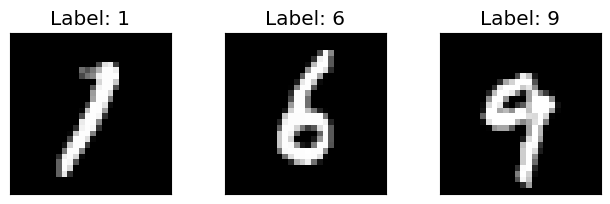

In [11]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


fig = plt.figure()
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

**Task 2**: define and call ``Net()``, a fully connected feedforward Neural Network made from an input layer (_what is the dimension of the input?_), hidden layers, and an output layer. The structure is [``input_dim``, 100, 50, ``output_dim``] (_what is the dimension of the output?_)
Moreover, the internal neurons have feature a ``Tanh`` _activation function action_, while the output layer is subjected to ``ReLU``.

- **Input**: 28x28=726 dimension of the input
- **Output**: 10 dimension of the output (the differen classes)

**Be careful!**: a reshape of the input is needed!

In [ ]:
# Build the NET as usual
class Net(nn.Module):
    def __init__(self): # Constractor
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) # First layer
        self.linear2 = nn.Linear(100,50)  # Middle layer
        self.final = nn.Linear(50,10) # Final layer

        # Activation function
        self.tanh = nn.Tanh() # More uesd because we have both positive and negative value
        self.relu = nn.ReLU()
        ## self.apply(self._init_weights) # To define the initial weights (if you want, as done in the previous lab - "Gradient_descent")

    """
    def HERE YOU CAN DEFINE THE WEIGHTS (look above)
    """
        
    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)

        # Application of the activation function to the different layer of out net
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.relu(self.final(x))

        return x

seed_num = 1
torch.manual_seed(seed_num)
net = Net() # Creation of the net

**Task 3 and 4**: define the loss (``nn.CrossEntropyLoss()``) and choose an optimizer (_Let us start with SGD?_). Fix the learning rate.
When we work with mini-batches, we can iterate over the DataLoarder (6000 iterations for a mini-batch of dimention 10) for some epochs, say 10. Complete the following cell. --> We're looking 10-by-10 value

We have two counter:
1. Epochs 
2. Minibatches -> how long I go through the data at each epoch

_Can you trace the loss and plot it with respect to the number of iterations (different from epochs)_?

In [ ]:
my_loss = nn.CrossEntropyLoss() # Definition of the loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.01) # Stocastic Gradient Descent to optimize the parameter

epoch = 10
i = 0

#### Useful quantities ####

train_losses = []

for ep in range(epoch):
    net.train() # Function of torch that set the training phase

    # For each data, we go though the data 10 times (10-by-10)
    for data in train_loader: # train_loader all data devided in minibatches
          i += 1
          x, y = data

          ### set zero grad on the optimizer
          optimizer.zero_grad()
          
          ## compute output
          output = net(x) # The evaluation of the net over the input

          # compute the loss
          loss = my_loss(output, y)

          #compute the gradients
          loss.backward() # Optimization step

          # optimizer update
          optimizer.step() 

          if i % 200 == 199:    # print every 10*200 = 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (ep + 1, i + 1, loss.item()))
              running_loss = 0.0
              train_losses.append(loss.item())
    # i = 0

[1,   200] loss: 2.201
[1,   400] loss: 1.749
[1,   600] loss: 2.188
[1,   800] loss: 1.706
[1,  1000] loss: 0.994
[1,  1200] loss: 0.990
[1,  1400] loss: 0.557
[1,  1600] loss: 1.403
[1,  1800] loss: 0.543
[1,  2000] loss: 0.528
[1,  2200] loss: 0.424
[1,  2400] loss: 0.459
[1,  2600] loss: 0.362
[1,  2800] loss: 0.370
[1,  3000] loss: 0.129
[1,  3200] loss: 0.476
[1,  3400] loss: 0.272
[1,  3600] loss: 0.233
[1,  3800] loss: 0.362
[1,  4000] loss: 0.245
[1,  4200] loss: 0.349
[1,  4400] loss: 0.206
[1,  4600] loss: 0.203
[1,  4800] loss: 0.061
[1,  5000] loss: 0.270
[1,  5200] loss: 0.137
[1,  5400] loss: 0.120
[1,  5600] loss: 0.183
[1,  5800] loss: 0.252
[1,  6000] loss: 0.147
[2,  6200] loss: 0.181
[2,  6400] loss: 0.223
[2,  6600] loss: 0.503
[2,  6800] loss: 0.146
[2,  7000] loss: 0.164
[2,  7200] loss: 0.071
[2,  7400] loss: 1.029
[2,  7600] loss: 0.358
[2,  7800] loss: 0.050
[2,  8000] loss: 0.305
[2,  8200] loss: 0.211
[2,  8400] loss: 0.307
[2,  8600] loss: 0.169
[2,  8800] 

Text(0, 0.5, 'Loss')

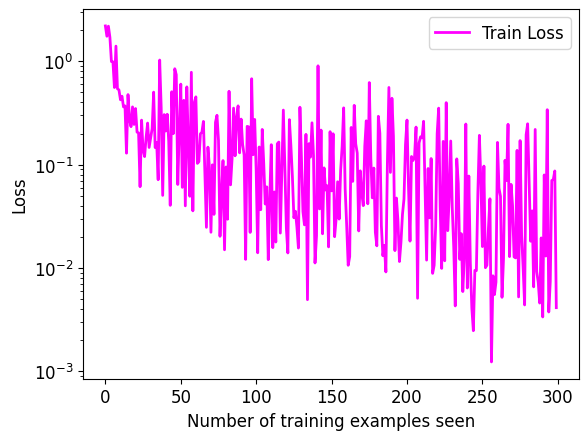

In [ ]:
fig = plt.figure()
plt.semilogy(range(len(train_losses)), train_losses, color='magenta')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Loss')

# The plot is such that because we have shuffle the data, so maybe he start to learn, but after
# something change (like go to another number) and so is not quite good as before
# BUT the important thing is that we can see a descent trend

**Task 5**: let us check how accurate is the model and which classes perform better!

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x)
        # print(output)
        
        for idx, i in enumerate(output):
            # This is a prediction that is correct
            if torch.argmax(i) == y[idx]:  #### idx indicates which sample I am taking from the mini-batch. The Output is a a vector of floats, the biggest is the one with higher probability
                correct +=1
            total +=1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)) 

# The result is related to the entropy (loss) that we use
# How we can decide the correct loss? 

Accuracy of the network on the 10000 test images: 96 %


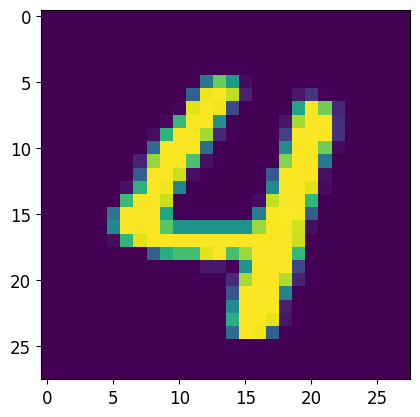

tensor(4)


In [16]:
plt.imshow(x[3].view(28, 28))
plt.show()
print(torch.argmax(net(x[3].view(-1, 784))[0]))

In [ ]:
# Compute the accuracy for each of the class to understand if some digits are well classified wrt the other
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, 784)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) ### returning the indices
        c = (predicted == labels).squeeze()

        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10): # Print the accuracy for each class
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 96 %
Accuracy of     3 : 96 %
Accuracy of     4 : 95 %
Accuracy of     5 : 95 %
Accuracy of     6 : 97 %
Accuracy of     7 : 96 %
Accuracy of     8 : 97 %
Accuracy of     9 : 96 %
